In [1]:
import lammps
import random
from tqdm import trange
import pymc3 as pm
import arviz as az
import numpy as np
import pymatgen as pmg
import theano.tensor as tt

# Initialisation
Create a lammps instance and load coordinates.

In [2]:
elements = pmg.Element('Li'), pmg.Element('Ni'), pmg.Element('O')
li, ni, o = elements

pairs = [(li,o), (ni,o), (o,o)]

charges = {li: 1,
           ni: 3,
           o: -2,}

bpp_def = {'Li_O_A'   : 456.783,
           'Li_O_rho' : 0.212,
           'Li_O_C'   : 0.0,
           'Ni_O_A'   : 1540.922,
           'Ni_O_rho' : 0.323,
           'Ni_O_C'   : 0.425,
           'O_O_A'    : 22764.7000,
           'O_O_rho'  : 0.1490,
           'O_O_C'    : 20.4}

bpp = {'Li_O_A'   : 456.783,
       'Li_O_rho' : 0.212,
       'Li_O_C'   : 0.0,
       'Ni_O_A'   : 1540.922,
       'Ni_O_rho' : 0.323,
       'Ni_O_C'   : 0.425,
       'O_O_A'    : 22764.7000,
       'O_O_rho'  : 0.1490,
       'O_O_C'    : 20.4}
         
def dex(elin): return elements.index(elin) + 1

In [3]:
def update_potentials(**kwargs):
    bpp.update(kwargs)
def set_potentials():
    for pair in pairs:
        lmp.command('pair_coeff {} {} {} {} {}'.format(dex(pair[0]),dex(pair[1]),
                                                       bpp['{}_{}_A'.format(pair[0], pair[1])],
                                                       bpp['{}_{}_rho'.format(pair[0], pair[1])],
                                                       bpp['{}_{}_C'.format(pair[0], pair[1])]
                                                      )
                   )

In [4]:
def init():
    lmp = lammps.Lammps(units='metal', style = 'full', args=['-log', 'none', '-screen', 'none'])
    lmp.command('read_data LiNiO2_coords.lmp')
    lmp.command('kspace_style pppm 1e-6')
    lmp.command('pair_style buck/coul/long 12.0')
    lmp.command('pair_coeff * * 0 1 0')

    for c in charges:
        lmp.command('set atom %d charge %f' % (elements.index(c)+1, charges[c]))
        
    return lmp

In [5]:
def simfunc(**kwargs):
    if min(kwargs.values()) > 0:
        update_potentials(**kwargs)
        set_potentials()
        lmp.run(0)
        out = lmp.system.forces
    else: out = np.ones([lmp.system.total,3])*999999999 # ThisAlgorithmBecomingSkynetCost
    return out

In [6]:
lmp = init()
with pm.Model() as model:
#  pm.TruncatedNormal -- truncated so never tries a negative    pm.Uniform
    Li_O_A      = pm.Normal("Li_O_A",    mu = bpp_def['Li_O_A'],    sd =  100)
    Li_O_rho    = pm.Normal("Li_O_rho",  mu = bpp_def['Li_O_rho'],  sd =  0.05)
#     Li_O_C      = pm.Normal("Li_O_C",    mu = bpp_def['Li_O_C'],    sd =  0.01)
    Ni_O_A      = pm.Normal("Ni_O_A",    mu = bpp_def['Ni_O_A'],    sd =  100)
    Ni_O_rho    = pm.Normal("Ni_O_rho",  mu = bpp_def['Ni_O_rho'],  sd =  0.05)
    Ni_O_C      = pm.Normal("Ni_O_C",    mu = bpp_def['Ni_O_C'],    sd =  0.05)
    O_O_A       = pm.Normal("O_O_A",     mu = bpp_def['O_O_A'],     sd =  100)
    O_O_rho     = pm.Normal("O_O_rho",   mu = bpp_def['O_O_rho'],   sd =  0.05)
    O_O_C       = pm.Normal("O_O_C",     mu = bpp_def['O_O_C'],     sd =  5)

    simulator = pm.Simulator('simulator', simfunc, observed=np.zeros([lmp.system.total, 3]))
    
    trace = pm.sample(step=pm.SMC(ABC=True, epsilon=5), draws=1000)
#     trace = pm.sample(step=pm.SMC(ABC=True, epsilon=3000, dist_func="sum_of_squared_distance"), draws=10)

Sample initial stage: ...
/Users/lmm82/.pyenv/versions/3.7.3/lib/python3.7/site-packages/pymc3/step_methods/smc.py:176: UserWarning: Warning: SMC-ABC methods are experimental step methods and not yet recommended for use in PyMC3!
  warnings.warn(EXPERIMENTAL_WARNING)
Stage: 0 Beta: 0.043 Steps: 25
Stage: 1 Beta: 0.111 Steps: 21
Stage: 2 Beta: 0.243 Steps: 2
Stage: 3 Beta: 0.608 Steps: 14
Stage: 4 Beta: 1.000 Steps: 3


/Users/lmm82/.pyenv/versions/3.7.3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12e375668>,
      dtype=object)

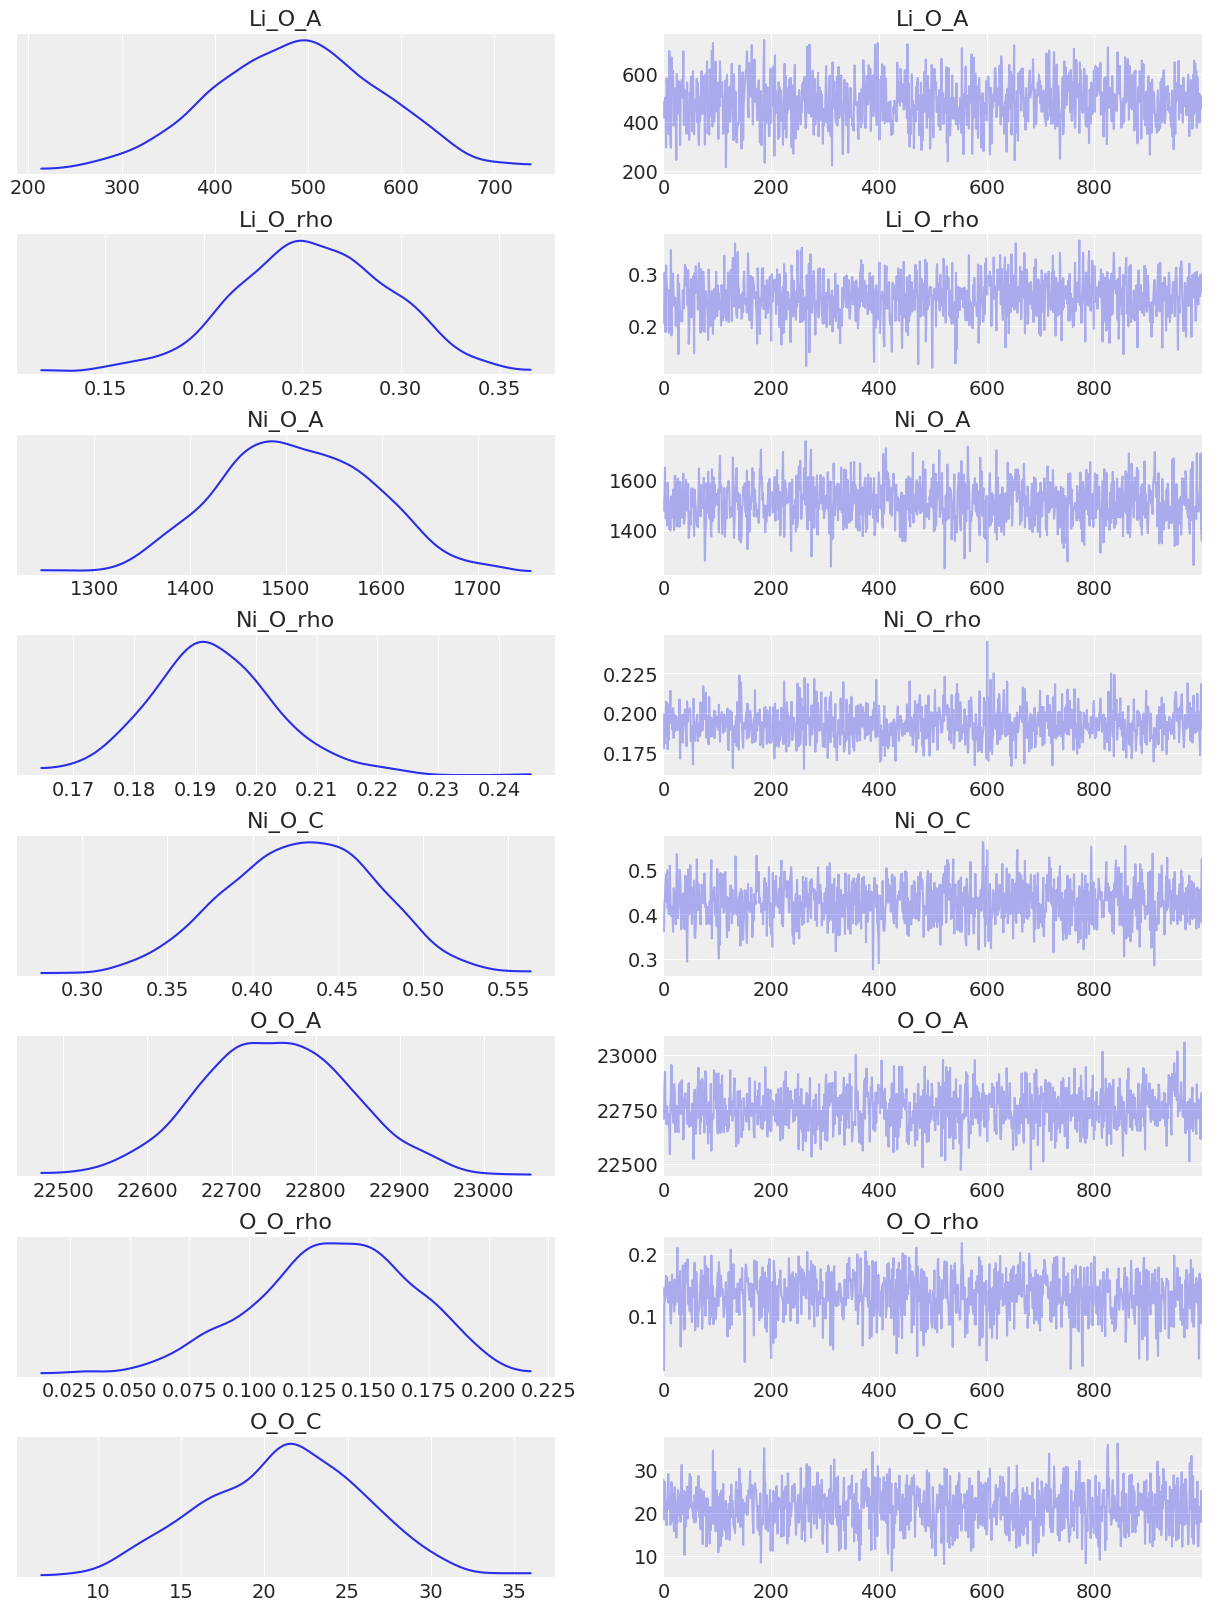

In [7]:
az.style.use('arviz-darkgrid')
az.plot_trace(trace)

/Users/lmm82/.pyenv/versions/3.7.3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))


array([<matplotlib.axes._subplots.AxesSubplot object at 0x13287f908>,
      dtype=object)

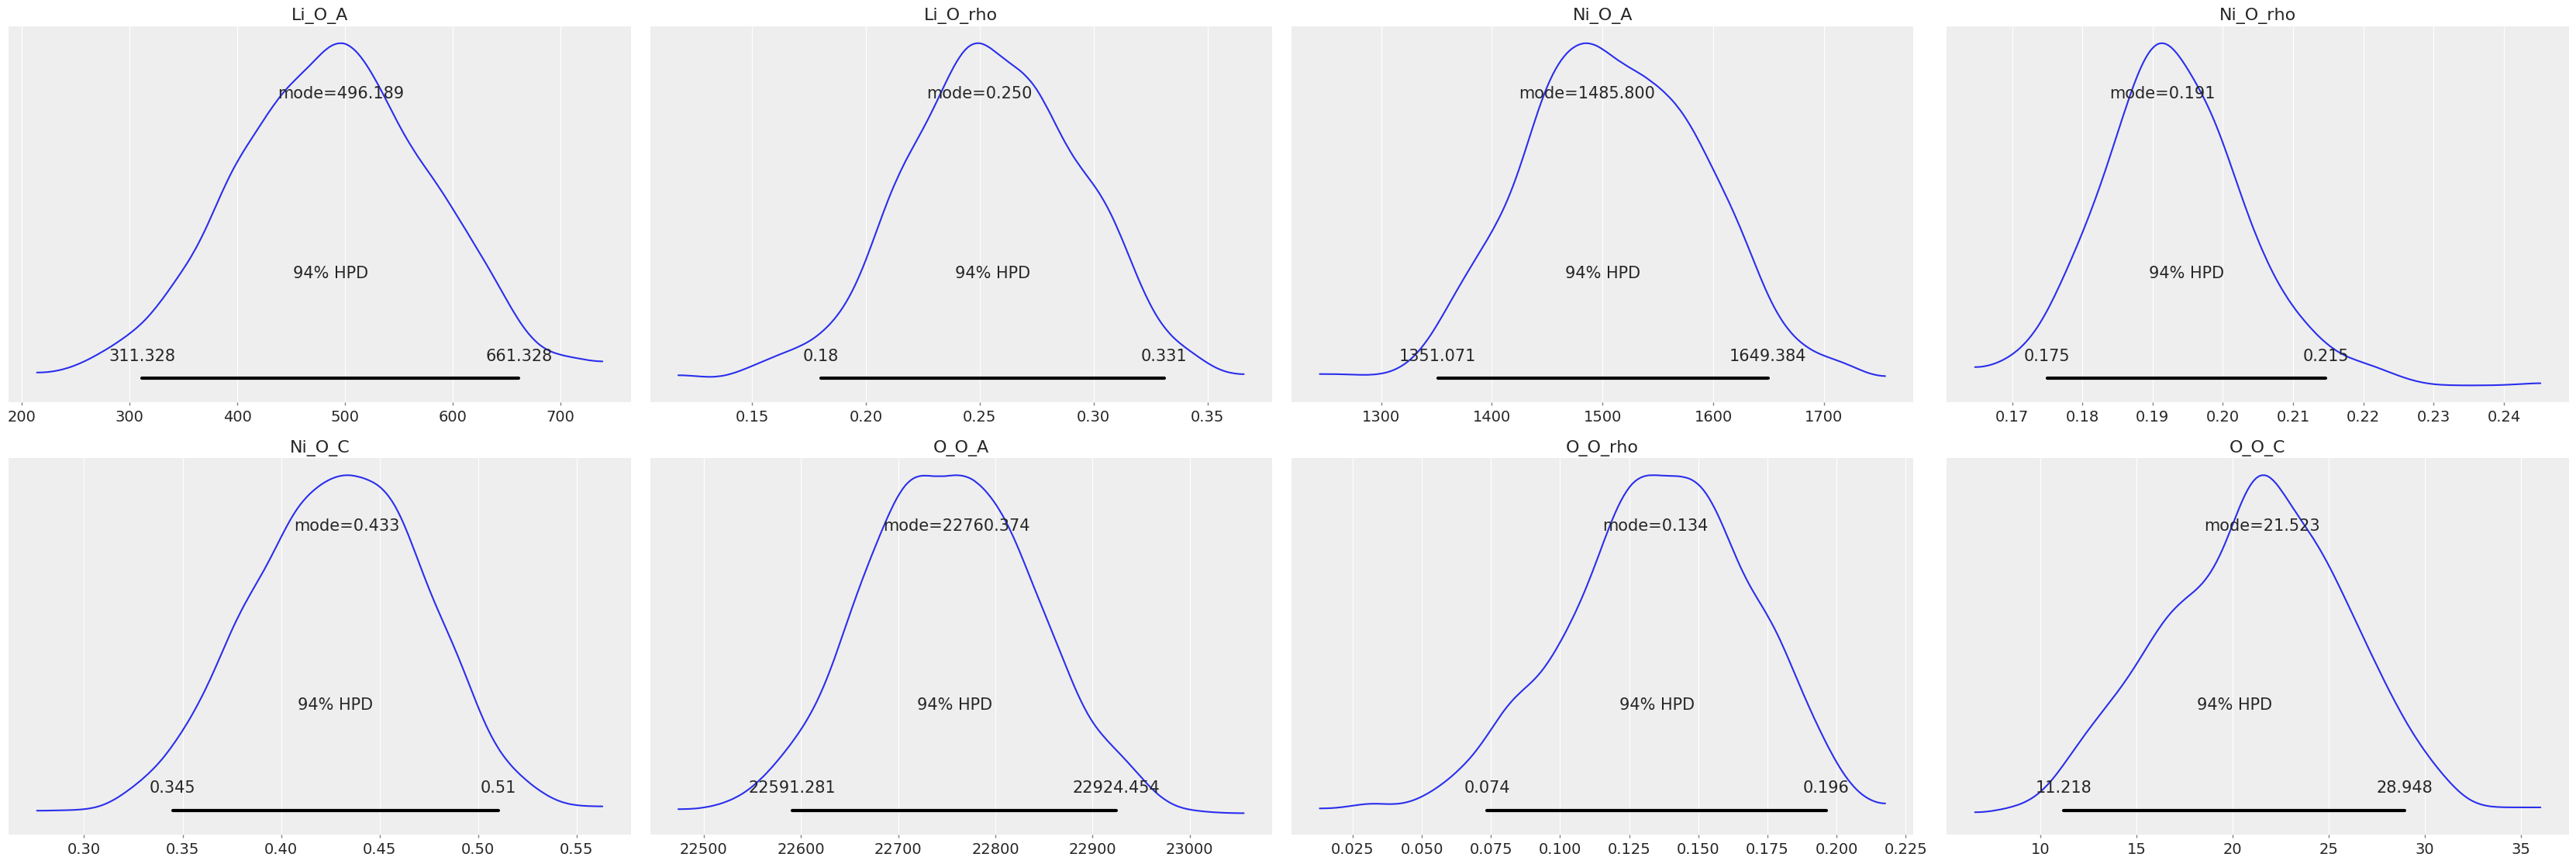

In [8]:
az.plot_posterior(trace, round_to = 3, point_estimate = 'mode')

/Users/lmm82/.pyenv/versions/3.7.3/lib/python3.7/site-packages/arviz/plots/forestplot.py:207: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  ticks.tick1On = False
/Users/lmm82/.pyenv/versions/3.7.3/lib/python3.7/site-packages/arviz/plots/forestplot.py:208: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  ticks.tick2On = False


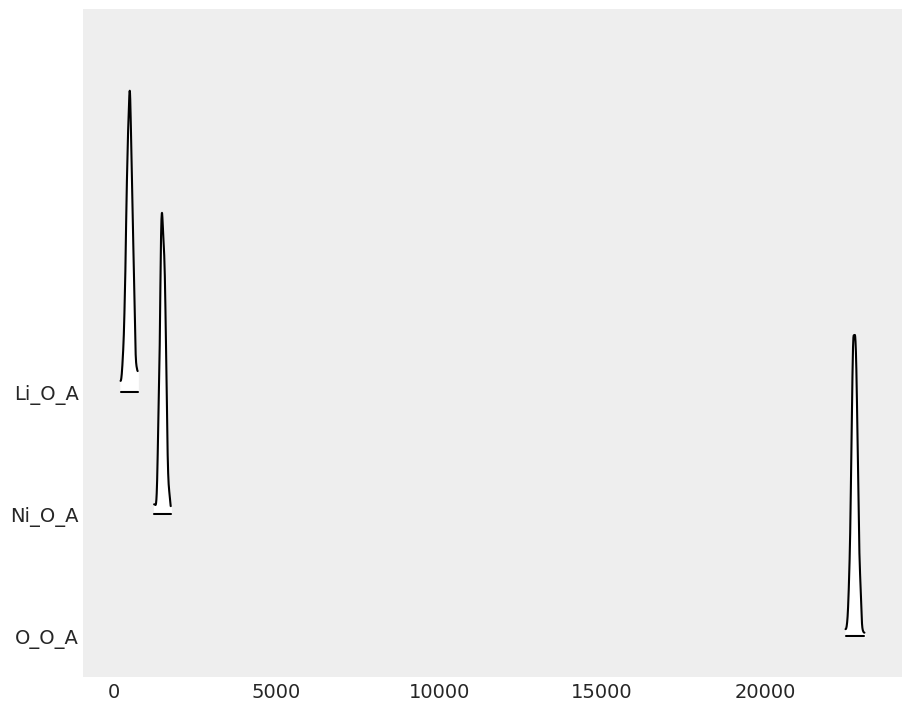

In [11]:
fig, axes = az.plot_forest(trace,
                           kind='ridgeplot',
                           var_names=['Li_O_A','Ni_O_A', 'O_O_A'],
                           combined=True,
                           ridgeplot_overlap=10,
                           colors='white',
                           figsize=(9, 7))